# Jupyter notebook for debugging

In [1]:
pip install -r requirements.txt


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

# Copied from `train` function in train_simple.py:L78
import yaml

device = 'cpu'
hyp = 'data/hyps/hyp.scratch-low.yaml'

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

In [3]:
from models.yolo import Model
from utils.general import check_dataset

cfg = 'models/yolov5n_kaist-rgbt.yaml'
data = 'data/kaist-rgbt.yaml'
data_dict = check_dataset(data)

nc = int(data_dict["nc"])  # number of classes
model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

Overriding model.yaml nc=1 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.MultiStreamConv           [3, 16, 6, 2, 2]              
  1                -1  1      9344  models.common.MultiStreamConv           [16, 32, 3, 2]                
  2                -1  1      9600  models.common.MultiStreamC3             [32, 32, 1]                   
  3                -1  1         0  models.common.Fusion                    ['concat', 2]                 
  4                -1  1      4224  models.common.Conv                      [64, 64, 1, 1]                
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 2]                
  6                -1  2     29184  models.common.C3                        [64, 64, 2]                   
  7                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               

In [4]:
anchors = model.model[-1].anchors

# [TODO] Draw anchors

## Sanity check: dataset
- Read images and label
- Visualize bounding boxes

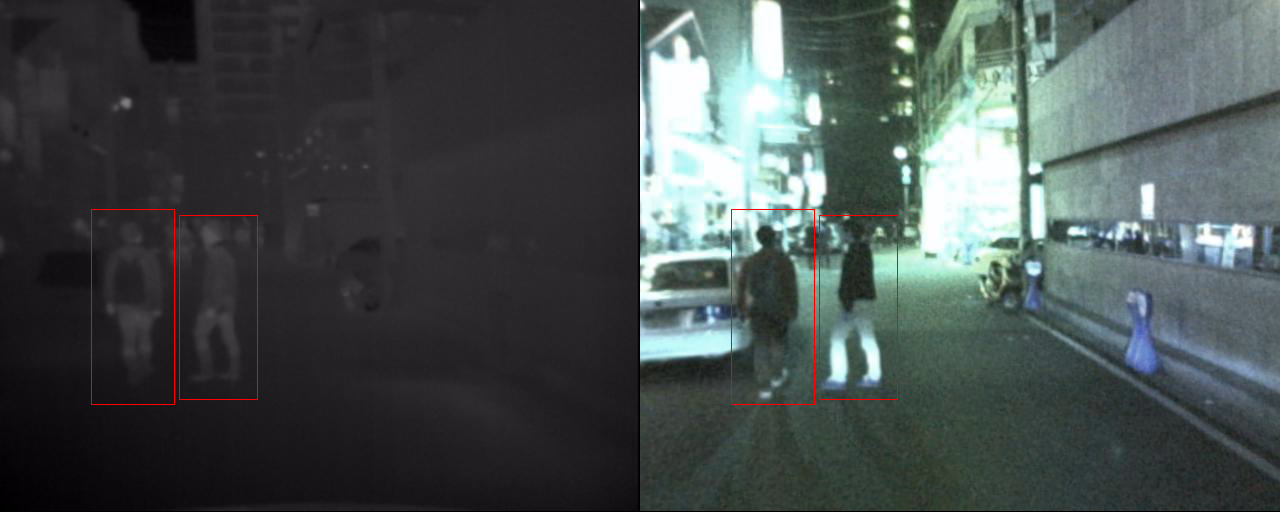

In [5]:
import cv2
import os
import numpy as np
from PIL import Image

annFile = 'datasets/kaist-rgbt/train/labels/set05_V000_I01219.txt'
lwirFile = annFile.replace('labels', 'images/lwir').replace('.txt', '.jpg')
visFile  = annFile.replace('labels', 'images/visible').replace('.txt', '.jpg')

# Read images
img_lwir = cv2.imread(lwirFile)
img_vis  = cv2.imread(visFile)

h, w = img_vis.shape[:2]

# Read labels
with open(annFile, 'r') as fp:
    labels = [x.split() for x in fp.read().strip().splitlines() if len(x)]

colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    # convert normalized bbox to pixel coordinates
    labels = np.array(labels, dtype=np.float32)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h

    cls = labels[:, 0]

    xyxy = np.zeros((len(labels), 4))
    xyxy[:, :2] = labels[:, 1:3]
    xyxy[:, 2:] = labels[:, 1:3] + labels[:, 3:5]
    xyxy = xyxy.astype(np.int16)

    for c, bb in zip(cls, xyxy):
        color = colors[c]
        cv2.rectangle(img_lwir, bb[:2], bb[2:], color)
        cv2.rectangle(img_vis,  bb[:2], bb[2:], color)

images = np.concatenate([img_lwir, img_vis], axis=1)
Image.fromarray(images)

## Sanity check: dataset class
- Visualize bounding boxes from dataset class

In [6]:
from utils.dataloaders import create_dataloader
from utils.general import check_img_size, colorstr

imgsz = 640
batch_size = 1
single_cls = False
seed = 0

train_path = data_dict["train"]
gs = max(int(model.stride.max()), 32)  # grid size (max stride)
imgsz = check_img_size(imgsz, gs, floor=gs * 2)  # verify imgsz is gs-multiple

train_loader, dataset = create_dataloader(
    train_path,
    imgsz,
    batch_size,
    gs,
    single_cls,
    hyp=hyp,
    augment=False,      # TODO: check if there is no bug when applying augmentation
    cache=None,
    rect=False,
    rank=-1,
    workers=8,
    image_weights=False,
    quad=False,
    prefix=colorstr("train: "),
    shuffle=False,      # No shuffle for debugging
    seed=seed,
    rgbt_input=True,
)


train: Scanning /home/a/hyu/kaist-rgbt/train.cache... 10030 images, 5595 backgrounds, 0 corrupt: 100%|██████████| 10030/10030 [00:00<?, ?it/s]


Dataset length: 10030
Adjusted frame index to 10029 as it was out of bounds.
datasets/kaist-rgbt/train/images/{}/set05_V000_I02915.jpg


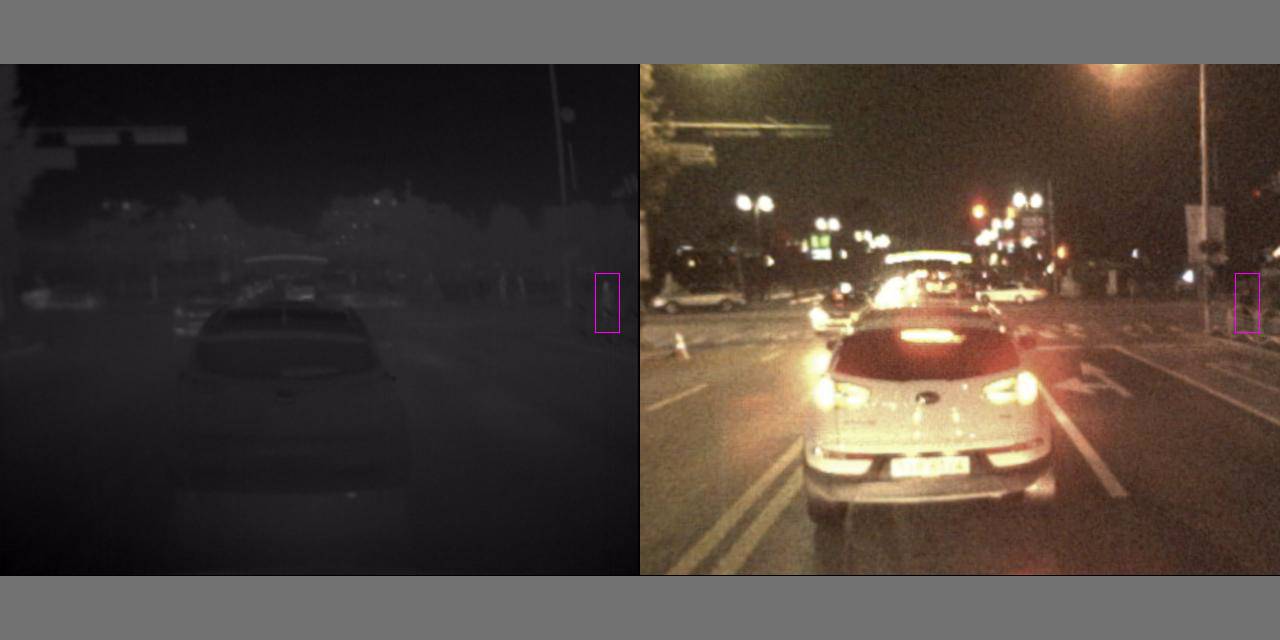

In [7]:
from utils.dataloaders import LoadRGBTImagesAndLabels
from utils.general import xywh2xyxy
import numpy as np

from PIL import Image

# 현재 frame 인덱스
frame = 12112

# 데이터셋 길이 확인
dataset_length = len(dataset)
print(f"Dataset length: {dataset_length}")

# frame 인덱스가 유효한지 확인하고 조정
if frame >= dataset_length:
    frame = dataset_length - 1  # 가장 큰 유효한 인덱스로 설정
    print(f"Adjusted frame index to {frame} as it was out of bounds.")

# Get a minibatch (fast)
imgs, targets, paths, shapes, _ = LoadRGBTImagesAndLabels.collate_fn([dataset[frame]])

idx = 0
img_lwir = imgs[0][idx].numpy().transpose((1, 2, 0))
img_vis = imgs[1][idx].numpy().transpose((1, 2, 0))
h, w = img_vis.shape[:2]

labels = targets.numpy()

colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    labels = labels[labels[:, 0] == idx, 1:]

    # convert normalized bbox to pixel coordinates
    labels = np.array(labels, dtype=np.float32)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h

    cls = labels[:, 0]

    xyxy = xywh2xyxy(labels[:, 1:5])
    xyxy = xyxy.astype(np.int16)

    img_lwir = np.ascontiguousarray(img_lwir)
    img_vis = np.ascontiguousarray(img_vis)

    for c, bb in zip(cls, xyxy):
        color = colors[c]
        cv2.rectangle(img_lwir, bb[:2], bb[2:], color)
        cv2.rectangle(img_vis, bb[:2], bb[2:], color)

images = np.concatenate([img_lwir, img_vis], axis=1)
print(paths[idx])
Image.fromarray(images)


## Run trained model
- Visualize bounding boxes from dataset class

In [8]:
import torch
from models.yolo import Model
from utils.torch_utils import select_device

weights = 'kaist-rgbt_best.pt'      # Train your own model!
data = 'data/kaist-rgbt.yaml'
cfg = 'models/yolov5s_kaist-rgbt.yaml'
hyp = 'data/hyps/hyp.scratch-low.yaml'
nc = 1
half = False  # use FP16 half-precision inference
dnn = False  # use OpenCV DNN for ONNX inference
device = select_device('cpu')

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

# inference
model.eval()
ims = [im.to(device, non_blocking=True).float() / 255 for im in imgs]    # For RGB-T input
with torch.no_grad():
    pred = model(ims)  # forward

YOLOv5 🚀 3609cae Python-3.8.10 torch-2.3.1+cu121 CPU


                 from  n    params  module                                  arguments                     
  0                -1  1      7040  models.common.MultiStreamConv           [3, 32, 6, 2, 2]              
  1                -1  1     37120  models.common.MultiStreamConv           [32, 64, 3, 2]                
  2                -1  1     37632  models.common.MultiStreamC3             [64, 64, 1]                   
  3                -1  1         0  models.common.Fusion                    ['concat', 2]                 
  4                -1  1     16640  models.common.Conv                      [128, 128, 1, 1]              
  5                -1  1    147712  models.common.Conv                      [128, 128, 3, 2]              
  6                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  7                -1  1    295424  models.common.Conv                      [128, 256, 3,

In [9]:
from utils.general import scale_boxes, non_max_suppression
import torch
import cv2

# 필수적인 변수 및 데이터 로드
conf_thres = 0.25  # confidence threshold
iou_thres = 0.45  # NMS IOU threshold
max_det = 1000  # maximum detections per image
classes = None
agnostic_nms = False  # class-agnostic NMS

# Example pred generation (replace with your actual model prediction)
# Here, `pred` should be the output from your model, having shape (batch_size, num_boxes, 5+num_classes)
pred = torch.rand((1, 100, 85))  # Example shape, modify according to your model's output

# Non-Max Suppression 적용
pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

# Resize predicted box
img_shapes = [(640, 640)]  # 실제 데이터에 맞게 조정
for i, det in enumerate(pred):  # 예측된 각 객체에 대해
    if len(det):
        # 원본 이미지 크기로 박스 크기 조정
        det[:, :4] = scale_boxes(img_shapes[i], det[:, :4], img_shapes[i])
        for *xyxy, conf, cls in reversed(det):
            label = f'{int(cls)} {conf:.2f}'
            color = (255, 0, 0)  # 박스 색상, 필요 시 수정
            pt1 = (int(xyxy[0]), int(xyxy[1]))
            pt2 = (int(xyxy[2]), int(xyxy[3]))
            cv2.rectangle(img_vis, pt1, pt2, color, 2)
            cv2.putText(img_vis, label, (pt1[0], pt1[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# 이미지 표시 (이미지 병합 필요 시)
# images = np.concatenate([img_lwir, img_vis], axis=1)
# Image.fromarray(images)



In [10]:
pred[0]

tensor([[6.55606e-01, 6.81593e-01, 1.22419e+00, 1.01418e+00, 9.96614e-01, 3.80000e+01],
        [2.79406e-01, 1.70032e-01, 6.96160e-01, 1.10424e+00, 9.64263e-01, 6.70000e+01],
        [2.47576e-01, 5.00731e-01, 5.62480e-01, 8.74734e-01, 9.61099e-01, 3.90000e+01],
        [2.11373e-01, 5.42910e-01, 1.03989e+00, 6.53149e-01, 9.50582e-01, 5.20000e+01],
        [0.00000e+00, 1.62293e-01, 1.88448e-01, 7.52283e-01, 9.40684e-01, 6.60000e+01],
        [3.38903e-01, 0.00000e+00, 1.07524e+00, 5.09409e-01, 9.33860e-01, 3.30000e+01],
        [1.15711e-02, 3.17606e-01, 1.02295e-01, 6.09616e-01, 9.13052e-01, 5.10000e+01],
        [8.75139e-02, 6.40243e-03, 7.80212e-01, 2.60143e-01, 9.10933e-01, 2.80000e+01],
        [7.99087e-01, 1.12848e-01, 1.07327e+00, 8.29536e-01, 8.96750e-01, 5.40000e+01],
        [3.45083e-02, 0.00000e+00, 3.37956e-01, 6.38048e-01, 8.85986e-01, 6.10000e+01],
        [3.79356e-01, 0.00000e+00, 7.68838e-01, 3.26785e-01, 8.76160e-01, 2.60000e+01],
        [6.75179e-01, 8.59460e-0